# Cálculo de $\pi$ en paralelo
### LEE ATENTAMENTE ESTE `notebook` EJECUTANDO SUS CELDAS. COMPLETA Y CONTESTA LAS CELDAS QUE CORRESPONDAN

Asegúrate de que estás ejecutando el código de este _notebook_ en la máquina y desde el directorio que quieres

**$\rightarrow$ ejecuta** (`shift` + `return`)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import quad

!echo "HOSTNAME     " `hostname`; 
!echo "CURRENT DIR  " `pwd`

HOSTNAME      sparkvm
CURRENT DIR   /home/vagrant/share/teaching/parallel-computing/ucaldas.20162/student


Calcularemos el valor de $\pi$ aproximando numéricamente la siguiente integral

$$\int_0^1 \frac{4}{1+x^2}dx \; \approx \; \sum_{i=0}^{N} \frac{1}{N} \frac{4}{1+(\frac{i}{N})^2}$$

Comprobamos primero que el valor de la integral es efectivamente $\pi$, usando las capacidades de integración numérica de Python y lo comparamos con la aproximación numérica con la sumatoria. 

actual pi                3.14159265359
numerical integration    3.14159265359
sumation approximation   3.14259248692


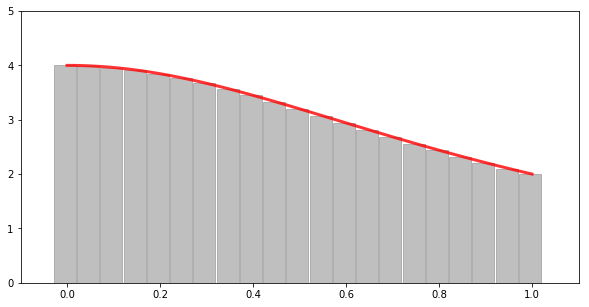

In [2]:
def f(x): 
    return 4. / (1.+x**2)
r = quad(f, 0,1)
print "actual pi               ", np.pi
print "numerical integration   ", r[0]

N=1000; i = np.arange(N)
num_approx = np.sum(4./(1+(1.*i/N)**2))/N
print "sumation approximation  ",num_approx

x = np.linspace(0,1,100)
ax = plt.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylim(0,5); ax.set_xlim(-0.1,1.1)
ax.plot(x,f(x), linewidth=3, color="r", alpha=0.8)
N=21
for i in np.linspace(0,1,N):
    ax.add_patch(plt.Rectangle((i-.6/N,0),1./N, f(i), alpha=0.5, color="gray", linewidth=1))


## Cálculo de $\pi$ en serie
Inspecciona y entiende el siguiente programa en C. Observa cómo se implementa la aproximación numérica por la sumatoria

**$\rightarrow$ salva el siguiente código ** (`shift` + `return`)

In [3]:
%%writefile files/pi_spmd_serial.c 

/**
  Based on Tim Mattons tutorial at Intel
  https://software.intel.com/en-us/courseware/249662
**/

#include <stdio.h>
#include <omp.h>

static double num_steps = 100000000;
double step;
int main ()
{
    int i,j;
    double x, pi, full_sum = 0.0;
    double start_time, run_time;

    step = 1.0/ num_steps;
    full_sum=0.0;

    start_time = omp_get_wtime();
    for (i=0;i< num_steps; i+=1){
        x = i*step;
        full_sum += 4.0/(1.0+x*x);
    }
    pi = step * full_sum;
    run_time = omp_get_wtime() - start_time;

    printf("pi secs\n");
    printf("%f %f \n",pi,run_time);
}


Writing files/pi_spmd_serial.c


**$\rightarrow$ compila el código ... ** (`shift` + `return`)

In [4]:
!make -f m/Makefile-p2.2.1 clean all

rm -rf *.o files/pi_spmd_serial /home/vagrant/share/teaching/parallel-computing/ucaldas.20162/student/utils/*.o
--------------------------------------
- bulding files/pi_spmd_serial
--------------------------------------
INCLUDES /home/vagrant/share/teaching/parallel-computing/ucaldas.20162/student/utils
SOURCES files/pi_spmd_serial.c	 /home/vagrant/share/teaching/parallel-computing/ucaldas.20162/student/utils/rlxutils.c
ROOT DIR /home/vagrant/share/teaching/parallel-computing/ucaldas.20162/student/utils
gcc -c -fopenmp -D LINUX -I/home/vagrant/share/teaching/parallel-computing/ucaldas.20162/student/utils files/pi_spmd_serial.c -o files/pi_spmd_serial.o
INCLUDES /home/vagrant/share/teaching/parallel-computing/ucaldas.20162/student/utils
SOURCES files/pi_spmd_serial.c	 /home/vagrant/share/teaching/parallel-computing/ucaldas.20162/student/utils/rlxutils.c
ROOT DIR /home/vagrant/share/teaching/parallel-computing/ucaldas.20162/student/utils
gcc -c -fopenmp -D LINUX -I/home/vagrant/share/te

**$\rightarrow$ ejecuta la aplicación ... ** (`shift` + `return`)

In [5]:
!./files/pi_spmd_serial

pi secs
3.141593 1.091673 


## Cálculo de $\pi$ en paralelo I
Observa la implementación en paralelo, en particular:
* el incremento de la variable `i` en el bucle `for` más interno hace que cada thread sume una parte del área de la integral (indicada con distintos colores en la figura siguiente)
* la variable `full_sum` se va acumulando la suma del área aproximada de la integral

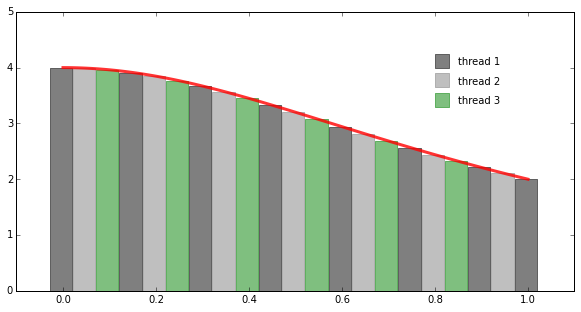

In [7]:
x = np.linspace(0,1,100)
ax = plt.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylim(0,5); ax.set_xlim(-0.1,1.1)
ax.plot(x,f(x), linewidth=3, color="r", alpha=0.8)
N = 21; cols = ["black","gray","green"]
for i in np.linspace(0,1,N):
    ax.add_patch(plt.Rectangle((i-.6/N,0),1./N, f(i), alpha=0.5, color=cols[int(i*N)%3], linewidth=1))
    
ax.add_patch(plt.Rectangle((0.8,4),0.03,0.25, color="black", linewidth=1, alpha=0.5))
ax.annotate("thread 1", xy=(0.85,4.05))

ax.add_patch(plt.Rectangle((0.8,3.65),0.03,0.25, color="gray", linewidth=1, alpha=0.5))
ax.annotate("thread 2", xy=(0.85,3.7))

ax.add_patch(plt.Rectangle((0.8,3.3),0.03,0.25, color="green", linewidth=1, alpha=0.5))
ax.annotate("thread 3", xy=(0.85,3.35))



# TAREA 1: Incluye el código paralelo en un bucle que lo ejecute con 1,2,3 y 4 threads

**$\rightarrow$ modifica y salva el siguiente código ** (`shift` + `return`)

In [ ]:
%%writefile files/pi_spmd_naive.c

/**
  Based on Tim Mattons' tutorial at Intel
  https://software.intel.com/en-us/courseware/249662
**/

#include <stdio.h>
#include <omp.h>

#define MAX_THREADS 4

static long num_steps = 100000000;
double step;
int main ()
{
    int i,j;
    double pi, full_sum = 0.0;
    double start_time, run_time;

    step = 1.0/(double) num_steps;

    printf("pi secs nthreads\n");

    j=4;

    //  =========== INICIA UN BUCLE DESDE j=1 HASTA MAX_THREADS ============
    omp_set_num_threads(j);
    full_sum=0.0;
    start_time = omp_get_wtime();

    #pragma omp parallel
    {
        int i;
        int id = omp_get_thread_num();
        int numthreads = omp_get_num_threads();
        double x;

        for (i=id;i< num_steps; i+=numthreads){
            x = (i+0.5)*step;
            full_sum = full_sum + 4.0/(1.0+x*x);
        }
    }

    pi = step * full_sum;
    run_time = omp_get_wtime() - start_time;
    printf("%f %f %d \n",pi,run_time,j);
    //  =========== CIERRA EL BUCLE AQUI ============

}


In [ ]:
!make -f m/Makefile-p2.2.2 clean all

In [ ]:
!./files/pi_spmd_naive

## Cálculo de $\pi$ en paralelo II
Observa ahora el siguiente código. Lo que queremos es que cada thread tenga su variable independiente para 
almacenar su suma parcial y, una vez que todos los threads hayan acabado, agregamos todas las sumas parciales.

Para ello creamos un array `sum[MAX_THREADS]` con un elemento para cada thread

# TAREA 2: Modifica el código paralelo para que cada thread acumule su suma sobre un elemento distinto del array y agrega las sumas parciales de cada thread despues del código paralelo



In [15]:
%%writefile files/pi_spmd_simple.c

/**
  Based on Tim Mattons' tutorial at Intel
  https://software.intel.com/en-us/courseware/249662
**/

#include <stdio.h>
#include <omp.h>

#define MAX_THREADS 4

static long num_steps = 100000000;
double step;
int main ()
{
    int i,j;
    double pi, full_sum = 0.0;
    double start_time, run_time;
    
    // array con un elemento para cada thread
    double sum[MAX_THREADS];

    step = 1.0/(double) num_steps;

    printf("pi secs nthreads\n");

    j=4;

    //  =========== INICIA UN BUCLE DESDE j=1 HASTA MAX_THREADS ============
    omp_set_num_threads(j);
    full_sum=0.0;
    start_time = omp_get_wtime();

    #pragma omp parallel
    {
        int i;
        int id = omp_get_thread_num();
        int numthreads = omp_get_num_threads();
        double x;

        sum[id] = 0.0;

        for (i=id;i< num_steps; i+=numthreads){
            x = (i+0.5)*step;
            // ==== MODIFICA LA SIGUIENTE LINEA ====
            // para que cada thread actualice su elemento del array 'sum' y no la suma global
            full_sum = full_sum + 4.0/(1.0+x*x);
        }
    }

    // ==== ANADE UN BUCLE PARA SUMAR LOS ELEMENTOS DEL ARRAY 'sum'
    // y almacenar el total en la variable 'full_sum'


    
    pi = step * full_sum;
    run_time = omp_get_wtime() - start_time;
    printf("%f %f %d \n",pi,run_time,j);
    
    
    //  =========== CIERRA EL BUCLE AQUI ============


}


Writing files/pi_spmd_simple.c


In [ ]:
!make -f m/Makefile-p2.2.3 clean all

In [19]:
!./files/pi_spmd_simple

pi secs nthreads
3.141593 2.441078 1 
3.141593 2.437770 2 
3.141593 2.160750 3 
3.141593 2.269115 4 


# PREGUNTAS:
* ¿Por qué la primera implementación en paralelo no da el valor correcto de $\pi$?
* ¿Observas alguna anomalía en la última implementación? ¿Cuál?
* ¿A qué se debe?

--- TU RESPUESTA AQUí (double click) ---